# Car Crashes
In this Jupyter Notebook, we will examine the number of car crashes that occured in each neighborhood in the City of Pittsburgh during 2020. We will be using two datasets from the WPRDC: **Pittsburgh Neighborhoods** and **Allegheny County Crash Data**. Use the code block below to load them from the WPRDC website.

In [18]:
#Imports pandas, geopandas, and matplotlib
import pandas as pd
import geopandas
import matplotlib.pyplot as plt

#Takes a GeoJSON of all neighborhoods in City of Pittsburgh and turns it into a GeoDataFrame indexed by neighborhood
neighborhood_url = "https://data.wprdc.org/dataset/e672f13d-71c4-4a66-8f38-710e75ed80a4/resource/4af8e160-57e9-4ebf-a501-76ca1b42fc99/download/pittsburghpaneighborhoods-.geojson"
neighborhood_gdf = geopandas.read_file(neighborhood_url).set_index('hood')

#Takes a CSV of all reported crashes in Allegheny County in 2020 and turns it into a GeoDataFrame of Points
crashes_2020_url = "https://data.wprdc.org/datastore/dump/514ae074-f42e-4bfb-8869-8d8c461dd824"
crashes_2019_url = "https://data.wprdc.org/datastore/dump/cb0a4d8b-2893-4d20-ad1c-47d5fdb7e8d5"
crashes_2018_url = "https://data.wprdc.org/dataset/3130f583-9499-472b-bb5a-f63a6ff6059a/resource/48f30bee-e404-4cf5-825b-b0da3c975e45/download/crash-data-2018.csv"
crashes_2017_url = "https://data.wprdc.org/datastore/dump/bf8b3c7e-8d60-40df-9134-21606a451c1a"
crashes_2016_url = "https://data.wprdc.org/datastore/dump/9ccea350-e062-45e2-ade5-45e9378f40d2"
crashes_df=pd.concat([pd.read_csv(crashes_2020_url,low_memory=False).dropna(subset=['DEC_LAT', 'DEC_LONG'])[['DEC_LAT','DEC_LONG']],
                          pd.read_csv(crashes_2019_url,low_memory=False).dropna(subset=['DEC_LAT', 'DEC_LONG'])[['DEC_LAT','DEC_LONG']],
                          pd.read_csv(crashes_2018_url,low_memory=False).dropna(subset=['DEC_LAT', 'DEC_LONG'])[['DEC_LAT','DEC_LONG']],
                          pd.read_csv(crashes_2017_url,low_memory=False).dropna(subset=['DEC_LAT', 'DEC_LONG'])[['DEC_LAT','DEC_LONG']],
                          pd.read_csv(crashes_2016_url,low_memory=False).dropna(subset=['DEC_LAT', 'DEC_LONG'])[['DEC_LAT','DEC_LONG']]
                         ],ignore_index=True)
    
crashes_gdf = geopandas.GeoDataFrame(crashes_df, geometry=geopandas.points_from_xy(crashes_df.DEC_LONG, crashes_df.DEC_LAT, crs=4326))

#Corrects odditity in neighborhood_gdf which has Perry North's area at 0.0 square miles
neighborhood_gdf.at['Perry North','sqmiles'] = 1.212

## Reformatting the Data
Unfortunately, the car crashes data set does not have a neighborhood associated with each car crash, which means we'll have to use the latitude and longitude of each incident and the geometry of the neighborhoods to figure out which neighborhood each crash took place in, if any. The code block below assigns car crashes to neighborhoods and counts the number of car crashes per neighborhood.

In [20]:
#New pittsburgh_crashes GeoDataFrame contains all crashes in any Pittsburgh neighborhood with a column for neighborhood
#Also adds a column to the neighborhood_gdf for the number of crashes in each neighborhood
pittsburgh_crashes = geopandas.GeoDataFrame(columns=crashes_gdf.columns.append(pd.Index(['hood'])), geometry='geometry', crs=4326)
crash_count = []
for i in neighborhood_gdf.index:
    bool_crashes = crashes_gdf.within(neighborhood_gdf.loc[i].geometry)
    try:
        count = bool_crashes.value_counts().loc[True]
    except KeyError:
        count = 0
    crash_count.append(count)
    neighborhood_crashes = crashes_gdf[bool_crashes].assign(hood=i)
    pittsburgh_crashes = pd.concat([neighborhood_crashes, pittsburgh_crashes])
try:
    neighborhood_gdf.insert(0, "crashes", pd.to_numeric(pd.Series(crash_count, index=neighborhood_gdf.index)))
except ValueError:
    neighborhood_gdf['crashes'] = pd.to_numeric(pd.Series(crash_count, index=neighborhood_gdf.index))

## Checking Our Code
As that's a fair amount of unintuitive code above, we should probably check that it works. To do this we, can plot the data set of crashes in Allegheny County and our subset of crashes in the City of Pittsburgh.

(40.1, 40.7)

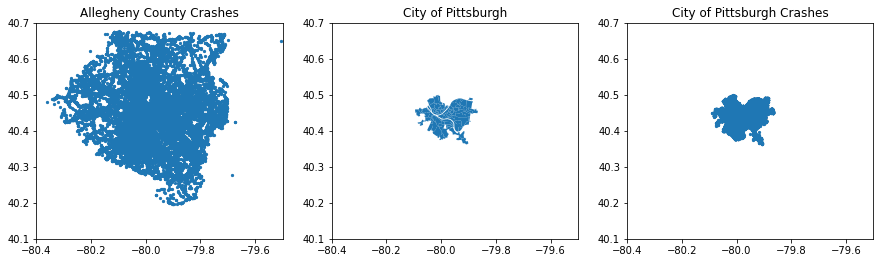

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))

#Creates subplot of all crashes in Allegheny County in 2020 with crashes_gdf
crashes_gdf.plot(ax=axes[0], markersize=5)
axes[0].set_title('Allegheny County Crashes')
axes[0].set_xlim(-80.4, -79.5)
axes[0].set_ylim(40.1,40.7)

#Creates subplot of the neighborhoods of the City of Pittsburgh with neighborhood_gdf
neighborhood_gdf.plot(ax=axes[1])
axes[1].set_title('City of Pittsburgh')
axes[1].set_xlim(-80.4, -79.5)
axes[1].set_ylim(40.1,40.7)

#Creates a subplot of all crashes in the City of Pittsburgh in 2020 with pittsburgh_crashes
pittsburgh_crashes.plot(ax=axes[2], markersize=5)
axes[2].set_title('City of Pittsburgh Crashes')
axes[2].set_xlim(-80.4, -79.5)
axes[2].set_ylim(40.1,40.7)

As we can see above, the Allegheny County Crashes plot clearly resembles Allegheny County (with the exception of one oddball point) while the City of Pittsburgh Crashes plot takes the size and shape of the city.

## The Metric
While most of our work is done, we need a better metric to discover which neighborhood is the best to live in, as the sheer number of car crashes is largely affected by the area of the neighborhood. We'll be using the crashes per square mile metric. This should be pretty easy to find as we already have both the number of crashes in and the area of each neighborhood. The below code finds that metric for each neighborhood and plots the data.

(-80.10681505991923, -79.85429464126214, 40.354642646539126, 40.50793371245118)

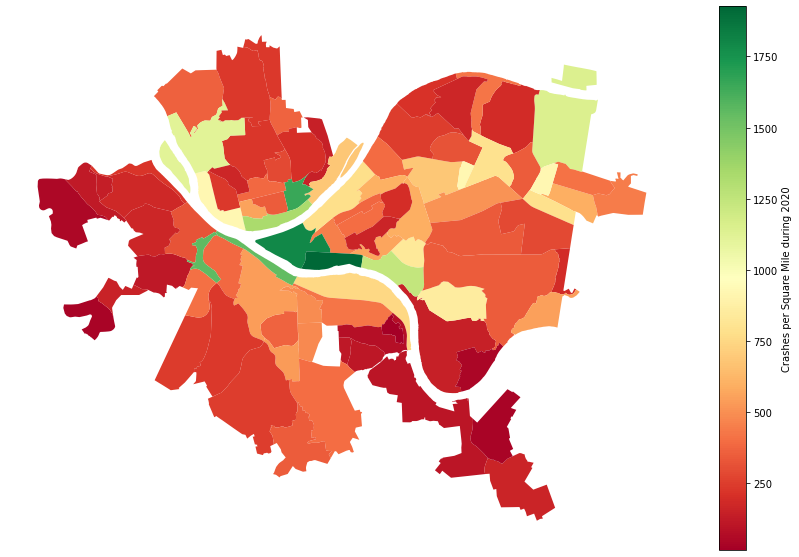

In [22]:
#Adds a column for crashes per square mile to neighborhood_gdf and plots it
neighborhood_gdf = neighborhood_gdf.assign(crash_sqmile = lambda x: x['crashes'] / x['sqmiles'])
neighborhood_gdf.plot(column='crash_sqmile',
                      cmap="RdYlGn",
                      legend=True,
                      legend_kwds={'label':'Crashes per Square Mile during 2020'},
                      figsize=(15,10))
plt.axis('off')

## Rankings
Now it's time to rank the neighborhoods of Pittsburgh by crashes per square mile!

In [23]:
total=list(neighborhood_gdf[['crashes','sqmiles']].sum())
print("The neighborhoods of Pittsburgh as a whole averaged " + str(int(total[0]/total[1])) + " crashes per square mile from 2016 through 2020.")
print("Let's see how each neighborhood contributed.\n")

sort_items = list(neighborhood_gdf.sort_values('crash_sqmile', ascending=False)['crash_sqmile'].items())
for i in range(len(sort_items)):
    pair = sort_items[i]
    print(str(i+1) + ". " + pair[0] + " - " + str(int(pair[1])))

The neighborhoods of Pittsburgh as a whole averaged 398 crashes per square mile from 2016 through 2020.
Let's see how each neighborhood contributed.

1. Bluff - 1926
2. Central Business District - 1798
3. East Allegheny - 1656
4. West End - 1560
5. South Shore - 1547
6. North Shore - 1336
7. South Oakland - 1240
8. Lincoln-Lemington-Belmar - 1146
9. Marshall-Shadeland - 1116
10. Homewood West - 924
11. Friendship - 924
12. Chateau - 919
13. Greenfield - 853
14. Central Oakland - 829
15. East Liberty - 793
16. Point Breeze North - 790
17. Strip District - 779
18. South Side Flats - 748
19. Troy Hill - 684
20. Bloomfield - 680
21. Polish Hill - 600
22. North Oakland - 597
23. Homewood South - 592
24. West Oakland - 567
25. Allegheny West - 553
26. Swisshelm Park - 550
27. Mount Washington - 538
28. Bon Air - 533
29. Shadyside - 511
30. Allentown - 488
31. Knoxville - 480
32. Crawford-Roberts - 449
33. East Hills - 441
34. Morningside - 421
35. South Side Slopes - 420
36. Homewood North -

## Normalization
Now let's try to normalize the results and give the neighborhoods a score from 0 to 100, with 0 being 0 crashes per square mile and 100 being the most crashes per square mile of any neighborhood.

In [25]:
max = neighborhood_gdf['crash_sqmile'].max()
neighborhood_gdf = neighborhood_gdf.assign(normal_score = lambda x: x['crash_sqmile'] / max)
neighborhood_gdf.head(10)

,crashes,objectid,fid_blockg,statefp10,countyfp10,tractce10,blkgrpce10,geoid10,namelsad10,mtfcc10,...,created_user,created_date,last_edited_user,last_edited_date,temp,Shape__Area,Shape__Length,geometry,crash_sqmile,normal_score
hood,,,,,,,,,,,,,,,,,,,,,
Chateau,352,1293,201,42,003,980600,1,420039806001,Block Group 1,G5030,...,pgh.admin,2020-08-14T14:52:26,pgh.admin,2020-08-14T14:52:26,None,1.068796e+07,19600.573085,"POLYGON ((-80.02999 40.45909, -80.02989 40.458...",919.060052,0.477036
Summer Hill,102,1294,10,42,003,261200,1,420032612001,Block Group 1,G5030,...,pgh.admin,2020-08-14T14:52:26,pgh.admin,2020-08-14T14:52:26,None,1.133208e+07,21174.473326,"POLYGON ((-80.01078 40.49975, -80.01073 40.499...",232.346241,0.120599
Northview Heights,116,1295,11,42,003,260900,1,420032609001,Block Group 1,G5030,...,pgh.admin,2020-08-14T14:52:26,pgh.admin,2020-08-14T14:52:26,None,8.743618e+06,13811.917169,"POLYGON ((-80.00327 40.48271, -80.00325 40.482...",370.607029,0.192363
Spring Hill-City View,131,1296,7,42,003,262000,1,420032620001,Block Group 1,G5030,...,pgh.admin,2020-08-14T14:52:26,pgh.admin,2020-08-14T14:52:26,None,1.754935e+07,18197.745741,"POLYGON ((-79.99761 40.47460, -79.99761 40.474...",207.936508,0.107929
Perry South,203,1297,8,42,003,261500,1,420032615001,Block Group 1,G5030,...,pgh.admin,2020-08-14T14:52:26,pgh.admin,2020-08-14T14:52:26,None,2.522420e+07,26390.549314,"POLYGON ((-80.01422 40.47745, -80.01435 40.477...",224.309392,0.116427
Fineview,71,1298,31,42,003,250900,2,420032509002,Block Group 2,G5030,...,pgh.admin,2020-08-14T14:52:26,pgh.admin,2020-08-14T14:52:26,None,6.962440e+06,12620.549035,"POLYGON ((-80.00198 40.46814, -80.00129 40.467...",284.000000,0.147410
Central Northside,100,1299,58,42,003,250300,1,420032503001,Block Group 1,G5030,...,pgh.admin,2020-08-14T14:52:26,pgh.admin,2020-08-14T14:52:26,None,7.219561e+06,14391.314228,"POLYGON ((-80.00228 40.45868, -80.00228 40.458...",386.100386,0.200404
Spring Garden,40,1300,59,42,003,241200,2,420032412002,Block Group 2,G5030,...,pgh.admin,2020-08-14T14:52:26,pgh.admin,2020-08-14T14:52:26,None,7.656111e+06,21431.626212,"POLYGON ((-79.98687 40.47413, -79.98598 40.472...",145.454545,0.075498
Troy Hill,263,1301,61,42,003,240600,2,420032406002,Block Group 2,G5030,...,pgh.admin,2020-08-14T14:52:26,pgh.admin,2020-08-14T14:52:26,None,1.283815e+07,29607.526014,"MULTIPOLYGON (((-79.97766 40.46653, -79.97771 ...",684.895833,0.355494
